In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
#taking only 1million rows for making it computation friendly
path = "C:\\Users\\HP\\OneDrive\\AppData\\Desktop\\!!74 pr\\data"
df = pd.read_csv(
    f"{path}\\airlines.csv",
    encoding="latin1",
    nrows=12300000)
df.head()
df.shape

(12300000, 29)

# New Feature: Total delay

In [ ]:
df['Total_Delay'] = df['ArrDelay'] + df['DepDelay']

# Target Feature: Disruption Types

DisruptionType
On Time      7397165
Delayed      4644401
Cancelled     229926
Diverted       28508
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Disruption Types')

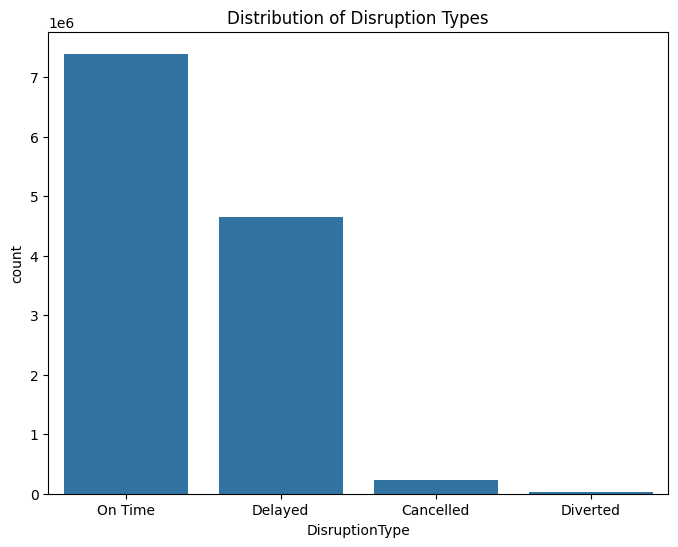

In [4]:

df['DisruptionType'] = np.select(
    [
        df['Cancelled'] == 1,
        df['Diverted'] == 1,
        df['Total_Delay'] > 5
    ],
    [
        'Cancelled',
        'Diverted',
        'Delayed'
    ],
    default='On Time'
)
print(df['DisruptionType'].value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='DisruptionType', order=df['DisruptionType'].value_counts().index)
plt.title('Distribution of Disruption Types')

# Balancing Data For each Label : Each Label has 250000 records 
# Total data points : 1M 
# Currently data has 29 features 

In [5]:
import pandas as pd
from sklearn.utils import resample

SAMPLES_PER_CLASS = 250_000

labels = ['On Time', 'Delayed', 'Cancelled', 'Diverted']
balanced_parts = []

for label in labels:
    subset = df[df['DisruptionType'] == label]

    sampled_subset = resample(
        subset,
        replace=len(subset) < SAMPLES_PER_CLASS,  # oversample only if needed
        n_samples=SAMPLES_PER_CLASS,
        random_state=42
    )

    balanced_parts.append(sampled_subset)

# Combine into one dataframe
balanced_1m_df = pd.concat(balanced_parts)

# Shuffle rows so classes are mixed
balanced_1m_df = balanced_1m_df.sample(frac=1, random_state=42).reset_index(drop=True)

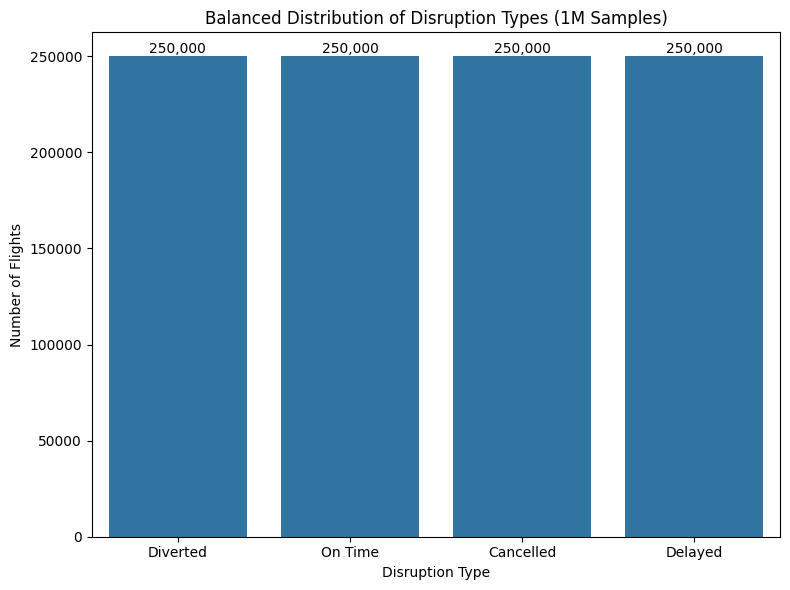

In [6]:


plt.figure(figsize=(8, 6))

ax = sns.countplot(
    data=balanced_1m_df,
    x='DisruptionType',
    order=balanced_1m_df['DisruptionType'].value_counts().index
)

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height()):,}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

plt.title('Balanced Distribution of Disruption Types (1M Samples)')
plt.xlabel('Disruption Type')
plt.ylabel('Number of Flights')
plt.tight_layout()
plt.show()


In [8]:
df = balanced_1m_df.drop(columns=['TailNum'])

# seasonality comparison 


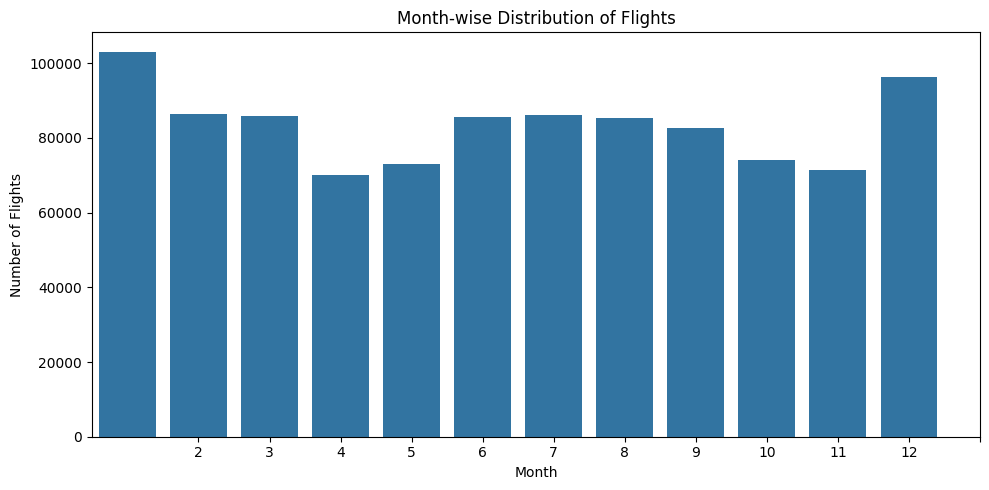

    Month  TotalFlights
0       1        103118
1       2         86522
2       3         85860
3       4         69966
4       5         72927
5       6         85587
6       7         86153
7       8         85325
8       9         82561
9      10         74192
10     11         71462
11     12         96327


In [9]:
#to check monthly balance of data
month_counts = (df.groupby('Month').size().reset_index(name='TotalFlights'))
month_counts
plt.figure(figsize=(10, 5))
sns.barplot(data=month_counts, x='Month', y='TotalFlights')
plt.title('Month-wise Distribution of Flights')
plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()
print(month_counts)

In [10]:
# Ensure numeric
df[['Year', 'Month', 'DayofMonth']] = df[['Year', 'Month', 'DayofMonth']].astype(int)

# Create Date
df['Date'] = pd.to_datetime(
    dict(
        year=df['Year'],
        month=df['Month'],
        day=df['DayofMonth']
    )
)
df['Date'].isna().sum()

np.int64(0)

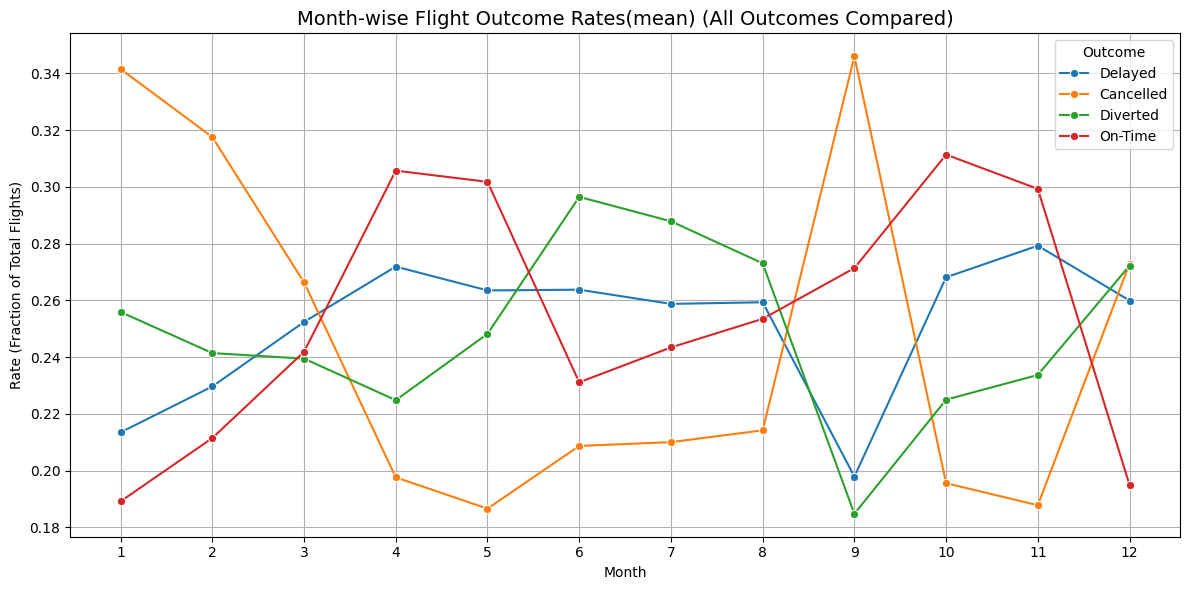

In [11]:
month_disruption = (
    df.groupby(['Month', 'DisruptionType'])
    .size()
    .reset_index(name='Count')
)
month_total = (
    df.groupby('Month')
    .size()
    .reset_index(name='TotalFlights')
)
month_rates = month_disruption.merge(
    month_total,
    on='Month',
    how='left'
)

month_rates['Rate'] = (
    month_rates['Count'] / month_rates['TotalFlights']
)
month_delay_rate = month_rates[
    month_rates['DisruptionType'] == 'Delayed'
][['Month', 'Rate']].rename(columns={'Rate': 'DelayRate'})

month_cancel_rate = month_rates[
    month_rates['DisruptionType'] == 'Cancelled'
][['Month', 'Rate']].rename(columns={'Rate': 'CancelRate'})

month_divert_rate = month_rates[
    month_rates['DisruptionType'] == 'Diverted'
][['Month', 'Rate']].rename(columns={'Rate': 'DivertRate'})

month_ontime_rate = month_rates[
    month_rates['DisruptionType'] == 'On Time'
][['Month', 'Rate']].rename(columns={'Rate': 'OnTimeRate'})
plt.figure(figsize=(12, 6))
# Plot all rates on the same axes
sns.lineplot(
    data=month_delay_rate,
    x='Month',
    y='DelayRate',
    marker='o',
    label='Delayed'
)

sns.lineplot(
    data=month_cancel_rate,
    x='Month',
    y='CancelRate',
    marker='o',
    label='Cancelled'
)

sns.lineplot(
    data=month_divert_rate,
    x='Month',
    y='DivertRate',
    marker='o',
    label='Diverted'
)

sns.lineplot(
    data=month_ontime_rate,
    x='Month',
    y='OnTimeRate',
    marker='o',
    label='On-Time'
)

# Formatting
plt.title('Month-wise Flight Outcome Rates(mean) (All Outcomes Compared)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Rate (Fraction of Total Flights)')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend(title='Outcome')

plt.tight_layout()
plt.show()


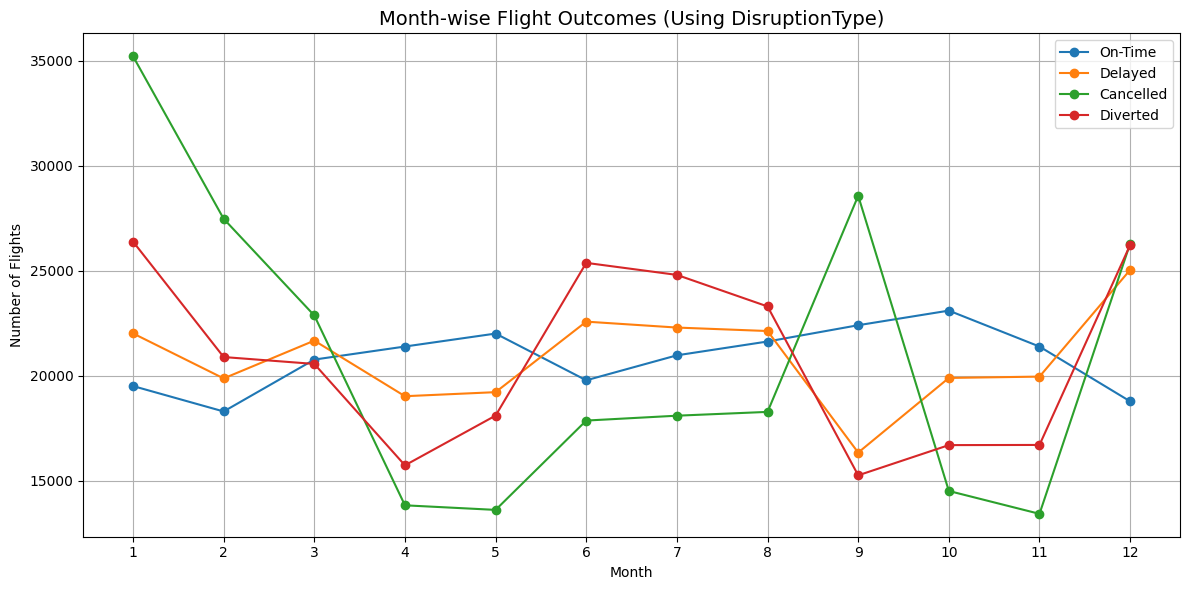

In [ ]:

# 1. Month-wise summary using DisruptionType

month_summary = (
    df.groupby(['Month', 'DisruptionType'])
      .size()
      .unstack(fill_value=0)
      .reset_index()
)

# ----------------------------------
# 2. Reindex months (1–12) to avoid x-axis bugs
# ----------------------------------
month_summary = (
    month_summary
    .set_index('Month')
    .reindex(range(1, 13), fill_value=0)
    .reset_index()
)

# ----------------------------------
# 3. Plot combined comparison (NO stacking)
# ----------------------------------
plt.figure(figsize=(12, 6))

plt.plot(month_summary['Month'], month_summary['On Time'],
         marker='o', label='On-Time')

plt.plot(month_summary['Month'], month_summary['Delayed'],
         marker='o', label='Delayed')

plt.plot(month_summary['Month'], month_summary['Cancelled'],
         marker='o', label='Cancelled')

plt.plot(month_summary['Month'], month_summary['Diverted'],
         marker='o', label='Diverted')

plt.title('Month-wise Flight Outcomes (Using DisruptionType)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Flights')
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# Monthly and weekly comparison

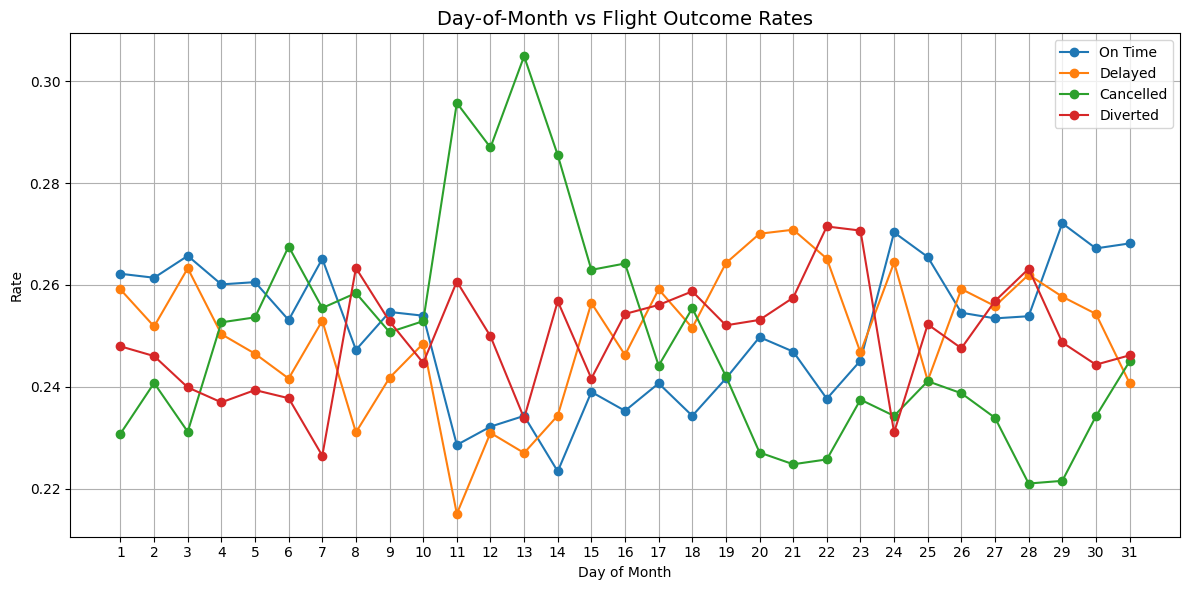

In [13]:
import matplotlib.pyplot as plt


# Month-day-wise outcome counts

month_day_counts = (
    df.groupby(['DayofMonth', 'DisruptionType'])
      .size()
      .unstack(fill_value=0)
)

# ----------------------------------
# Convert counts → rates
# ----------------------------------
month_day_rates = month_day_counts.div(
    month_day_counts.sum(axis=1),
    axis=0
)

# ----------------------------------
# Plot (NO stacking)
# ----------------------------------
plt.figure(figsize=(12, 6))

for outcome in ['On Time', 'Delayed', 'Cancelled', 'Diverted']:
    if outcome in month_day_rates.columns:
        plt.plot(
            month_day_rates.index,
            month_day_rates[outcome],
            marker='o',
            label=outcome
        )

plt.title('Day-of-Month vs Flight Outcome Rates', fontsize=14)
plt.xlabel('Day of Month')
plt.ylabel('Rate')
plt.xticks(range(1, 32))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


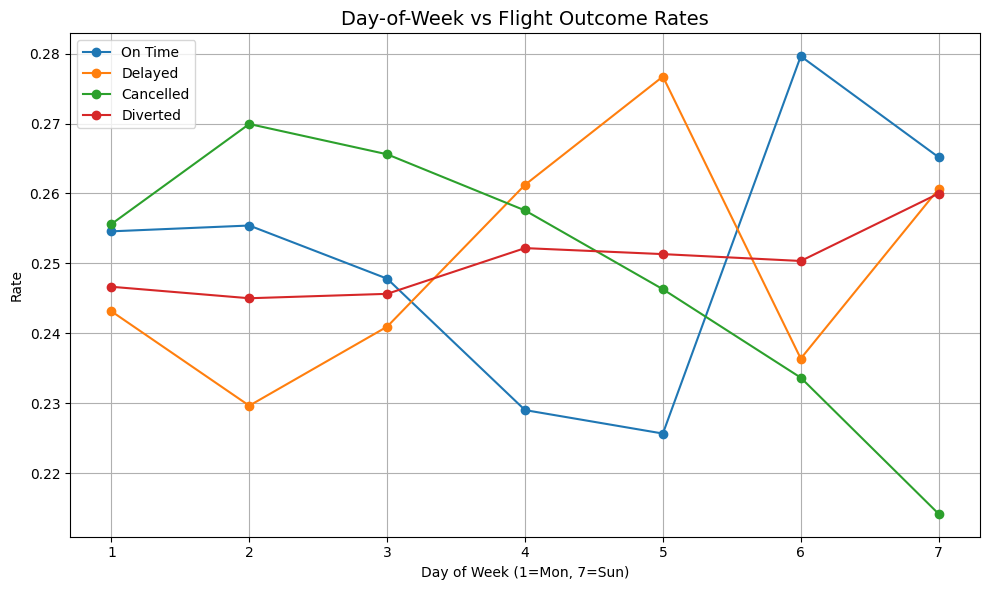

In [14]:
# ----------------------------------
# Weekday-wise outcome counts
# ----------------------------------
week_day_counts = (
    df.groupby(['DayOfWeek', 'DisruptionType'])
      .size()
      .unstack(fill_value=0)
)

# ----------------------------------
# Convert counts → rates
# ----------------------------------
week_day_rates = week_day_counts.div(
    week_day_counts.sum(axis=1),
    axis=0
)

# ----------------------------------
# Plot (NO stacking)
# ----------------------------------
plt.figure(figsize=(10, 6))

for outcome in ['On Time', 'Delayed', 'Cancelled', 'Diverted']:
    if outcome in week_day_rates.columns:
        plt.plot(
            week_day_rates.index,
            week_day_rates[outcome],
            marker='o',
            label=outcome
        )

plt.title('Day-of-Week vs Flight Outcome Rates', fontsize=14)
plt.xlabel('Day of Week (1=Mon, 7=Sun)')
plt.ylabel('Rate')
plt.xticks(range(1, 8))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Distance Comparison

In [15]:
df['Distance'].isna().sum()

np.int64(1762)

In [16]:
#route based median filling for distance

route_median = (df.dropna(subset=['Distance']).groupby(['Origin', 'Dest'])['Distance'].median())

df['Distance'] = df.apply(lambda r: route_median.get((r['Origin'], r['Dest']), r['Distance']),axis=1)

df['Distance'].isna().sum()

np.int64(1)

In [17]:

#  Create distance bins

distance_bins = [0, 250, 500, 1000, 1500, 2000, 3000, float('inf')]
distance_labels = [
    '0–250',
    '250–500',
    '500–1000',
    '1000–1500',
    '1500–2000',
    '2000–3000',
    '3000+'
]
df['DistanceBin'] = pd.cut(df['Distance'],bins=distance_bins,labels=distance_labels)

C:\Users\HP\AppData\Local\Temp\ipykernel_5612\3860983986.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['DistanceBin', 'DisruptionType'])


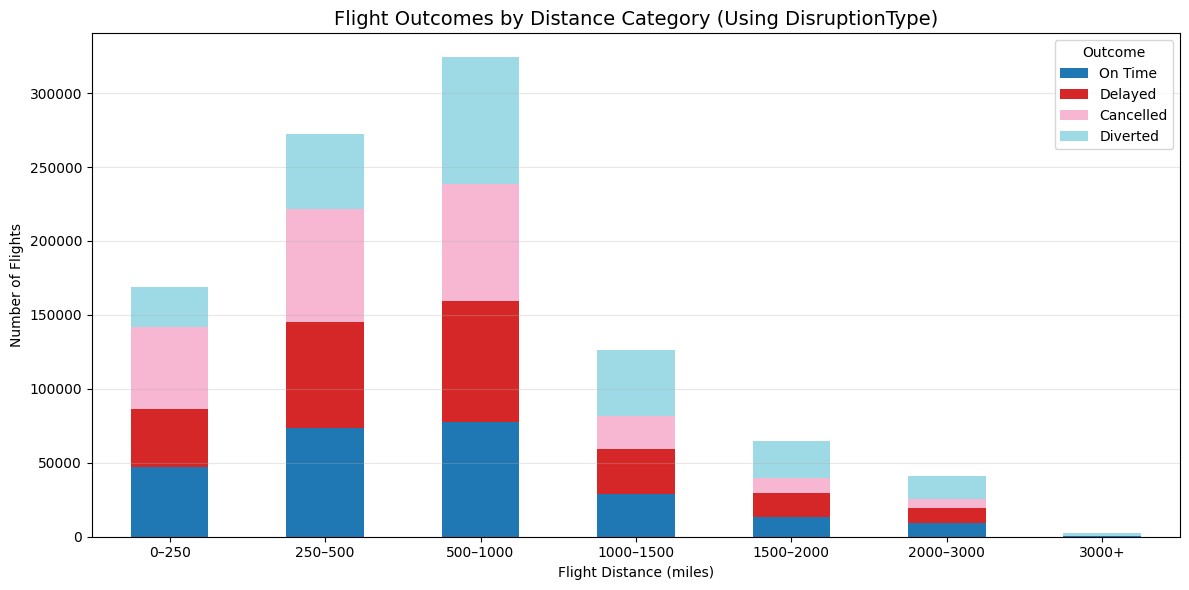

In [18]:
# ----------------------------------
# 2. Aggregate outcome COUNTS
#    (mutually exclusive, correct)
# ----------------------------------
distance_counts = (
    df.groupby(['DistanceBin', 'DisruptionType'])
      .size()
      .unstack(fill_value=0)
)

# ----------------------------------
# 3. Plot stacked bar chart (COUNTS)
# ----------------------------------
distance_counts[
    ['On Time', 'Delayed', 'Cancelled', 'Diverted']
].plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='tab20'
)

plt.title('Flight Outcomes by Distance Category (Using DisruptionType)', fontsize=14)
plt.xlabel('Flight Distance (miles)')
plt.ylabel('Number of Flights')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Outcome')

plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_5612\1932061561.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['DistanceBin', 'DisruptionType'])


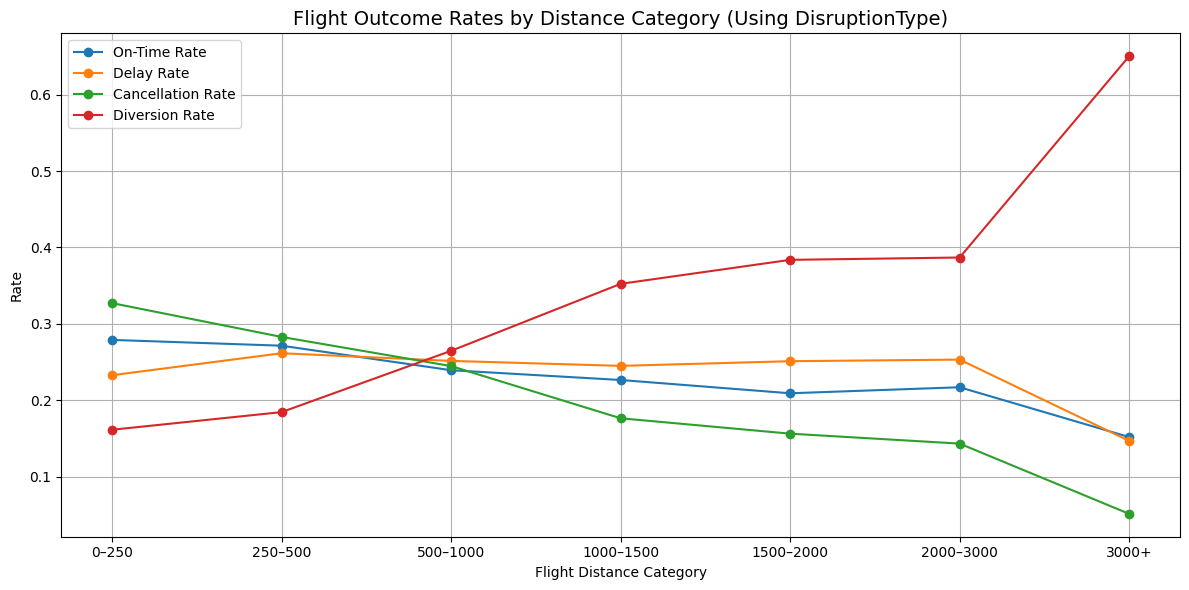

In [19]:
# ----------------------------------
# 1. Count outcomes per DistanceBin
# ----------------------------------
distance_counts = (
    df.groupby(['DistanceBin', 'DisruptionType'])
      .size()
      .unstack(fill_value=0)
)
# ----------------------------------
# 2. Convert counts → rates (means)
# ----------------------------------
distance_rates = distance_counts.div(
    distance_counts.sum(axis=1),
    axis=0
).reset_index()
# ----------------------------------
# 3. Plot outcome RATES on one graph
# ----------------------------------
plt.figure(figsize=(12, 6))

plt.plot(distance_rates['DistanceBin'], distance_rates['On Time'],
         marker='o', label='On-Time Rate')

plt.plot(distance_rates['DistanceBin'], distance_rates['Delayed'],
         marker='o', label='Delay Rate')

plt.plot(distance_rates['DistanceBin'], distance_rates['Cancelled'],
         marker='o', label='Cancellation Rate')

plt.plot(distance_rates['DistanceBin'], distance_rates['Diverted'],
         marker='o', label='Diversion Rate')

plt.title('Flight Outcome Rates by Distance Category (Using DisruptionType)', fontsize=14)
plt.xlabel('Flight Distance Category')
plt.ylabel('Rate')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_5612\2444380238.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['DistanceBin', 'DisruptionType'])


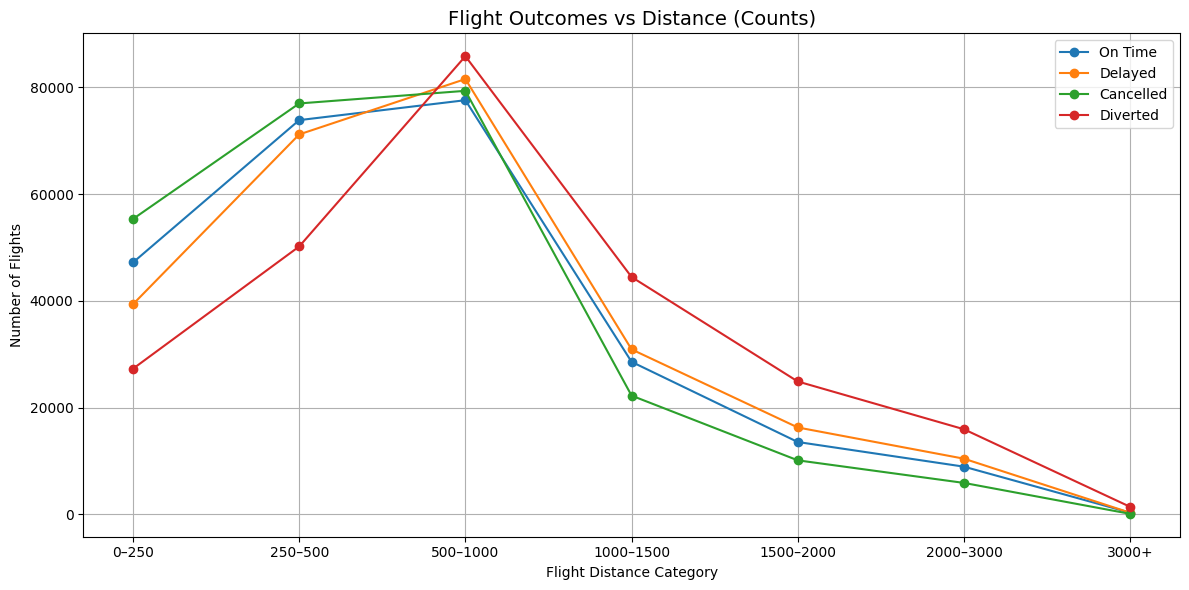

In [20]:
# ----------------------------------
# 1. Count outcomes per distance bin
# ----------------------------------
distance_counts = (
    df.groupby(['DistanceBin', 'DisruptionType'])
      .size()
      .unstack(fill_value=0)
)

# Ensure consistent order of distance bins (important for x-axis)
distance_counts = distance_counts.reindex(df['DistanceBin'].cat.categories)

# ------------
# 2. Line plot
# ------------
plt.figure(figsize=(12, 6))

for outcome in ['On Time', 'Delayed', 'Cancelled', 'Diverted']:
    if outcome in distance_counts.columns:
        plt.plot(
            distance_counts.index,
            distance_counts[outcome],
            marker='o',
            label=outcome
        )

plt.title('Flight Outcomes vs Distance (Counts)', fontsize=14)
plt.xlabel('Flight Distance Category')
plt.ylabel('Number of Flights')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


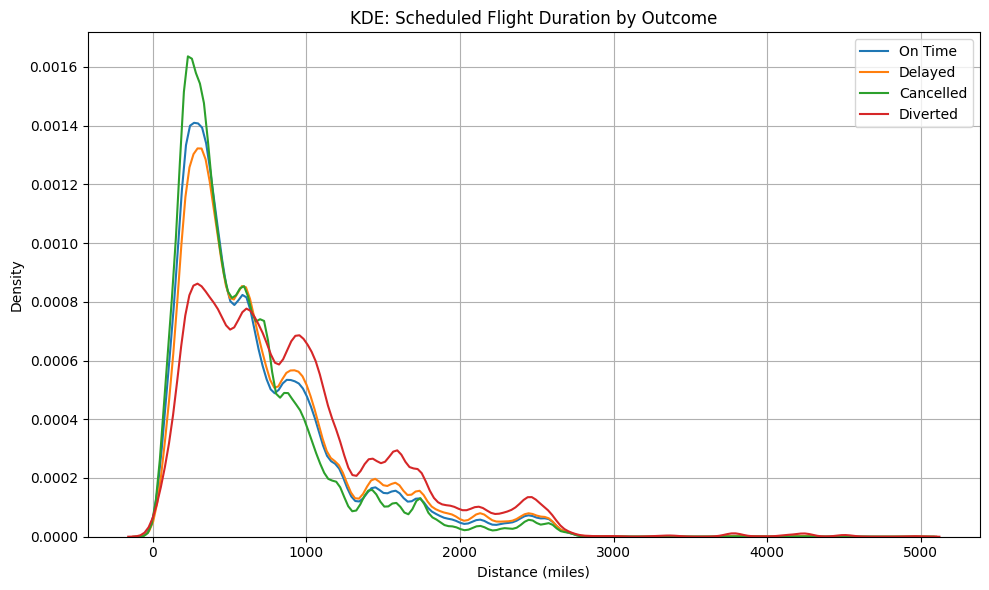

In [21]:

# Order for consistency
outcome_order = ['On Time', 'Delayed', 'Cancelled', 'Diverted']
plt.figure(figsize=(10, 6))
# ----------------------------------
# 1️⃣ KDE plot
# ----------------------------------
for outcome in outcome_order:
    subset = df[df['DisruptionType'] == outcome]

    sns.kdeplot(
        data=subset,
        x='Distance',
        label=outcome,
        fill=False
    )
plt.title('KDE: Scheduled Flight Duration by Outcome')
plt.xlabel('Distance (miles)')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Converting scheduled departure and arrival time to minutes 

In [22]:
# Converting from hhmm to minutes 
def hhmm_to_minutes(series):
    hours = series // 100
    minutes = series % 100
    return hours * 60 + minutes

# Fix scheduled times
df['CRSDepMin'] = hhmm_to_minutes(df['CRSDepTime'])
df['CRSArrMin'] = hhmm_to_minutes(df['CRSArrTime'])



# Handle 2400 → 1440
for col in ['CRSDepMin', 'CRSArrMin']:
    df.loc[df[col] == 1440, col] = 0

In [23]:
print(df['CRSArrMin'].isna().sum())
print(df['CRSDepMin'].isna().sum())


0
0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   ActualElapsedTime  500000 non-null   float64       
 1   AirTime            352071 non-null   float64       
 2   ArrDelay           500000 non-null   float64       
 3   ArrTime            502804 non-null   float64       
 4   CRSArrTime         1000000 non-null  int64         
 5   CRSDepTime         1000000 non-null  int64         
 6   CRSElapsedTime     994713 non-null   float64       
 7   CancellationCode   79594 non-null    object        
 8   Cancelled          1000000 non-null  int64         
 9   CarrierDelay       263495 non-null   float64       
 10  DayOfWeek          1000000 non-null  int64         
 11  DayofMonth         1000000 non-null  int64         
 12  DepDelay           750162 non-null   float64       
 13  DepTime            750162 no

In [25]:
class_df=df.copy()

In [26]:
class_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   ActualElapsedTime  500000 non-null   float64       
 1   AirTime            352071 non-null   float64       
 2   ArrDelay           500000 non-null   float64       
 3   ArrTime            502804 non-null   float64       
 4   CRSArrTime         1000000 non-null  int64         
 5   CRSDepTime         1000000 non-null  int64         
 6   CRSElapsedTime     994713 non-null   float64       
 7   CancellationCode   79594 non-null    object        
 8   Cancelled          1000000 non-null  int64         
 9   CarrierDelay       263495 non-null   float64       
 10  DayOfWeek          1000000 non-null  int64         
 11  DayofMonth         1000000 non-null  int64         
 12  DepDelay           750162 non-null   float64       
 13  DepTime            750162 no

# New Feature : Scheduled Elapsed Time = CRS Arrival Time - CRS Departure Time

In [27]:
df['ScheduledElapsedTime'] = df['CRSArrMin'] - df['CRSDepMin']
df.loc[df['ScheduledElapsedTime'] < 0, 'ScheduledElapsedTime'] += 1440
class_df['ScheduledElapsedTime'] = class_df['CRSArrMin'] - class_df['CRSDepMin']
class_df.loc[class_df['ScheduledElapsedTime'] < 0, 'ScheduledElapsedTime'] += 1440

In [28]:
df['ElapsedBin'] = pd.cut(df['ScheduledElapsedTime']
                          ,bins=[0, 60, 120, 180, 240, 300, 400, 600, 1000]
                          ,right=False)

class_df['ElapsedBin'] = pd.cut(df['ScheduledElapsedTime']
                          ,bins=[0, 60, 120, 180, 240, 300, 400, 600, 1000]
                          ,right=False)

C:\Users\HP\AppData\Local\Temp\ipykernel_5612\3024104711.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elapsed_rates = (df.groupby(['ElapsedBin', 'DisruptionType']).size().unstack(fill_value=0))


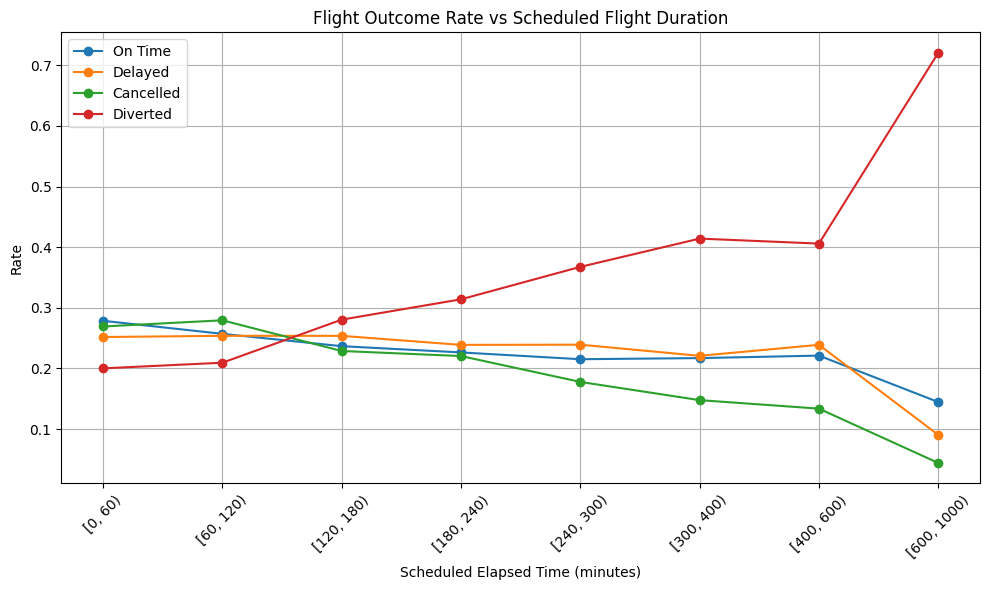

In [29]:
elapsed_rates = (df.groupby(['ElapsedBin', 'DisruptionType']).size().unstack(fill_value=0))
elapsed_rates = elapsed_rates.div(elapsed_rates.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
for col in ['On Time', 'Delayed', 'Cancelled', 'Diverted']:
    if col in elapsed_rates.columns:
        plt.plot(elapsed_rates.index.astype(str),
                 elapsed_rates[col],
                 marker='o',
                 label=col)

plt.xlabel('Scheduled Elapsed Time (minutes)')
plt.ylabel('Rate')
plt.title('Flight Outcome Rate vs Scheduled Flight Duration')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

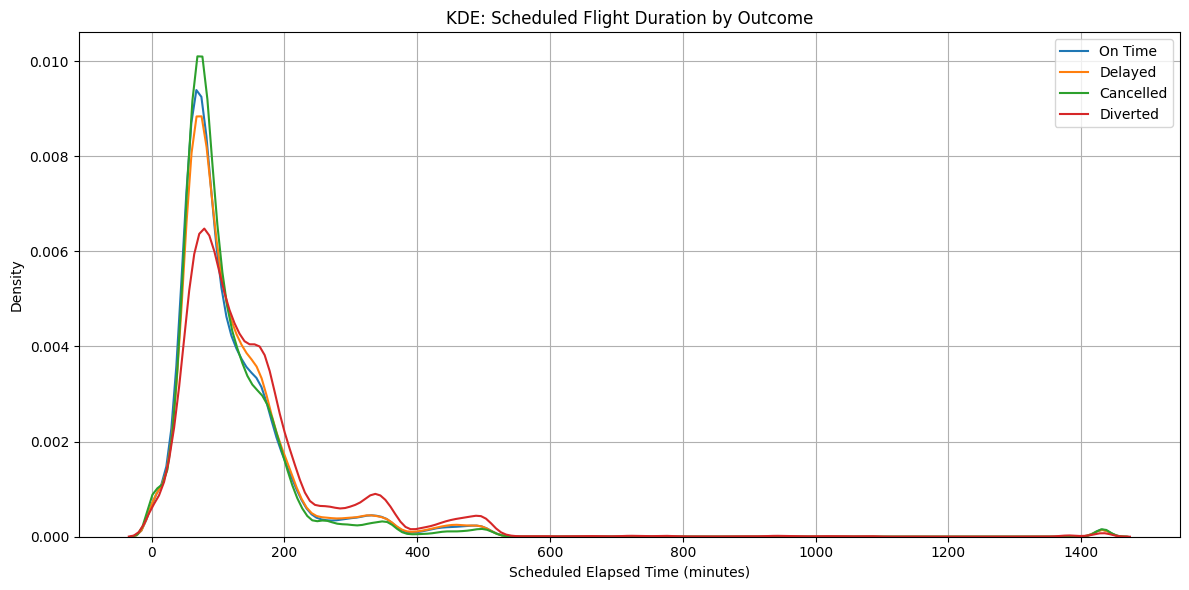

In [30]:
# Order for consistency
outcome_order = ['On Time', 'Delayed', 'Cancelled', 'Diverted']
plt.figure(figsize=(12, 6))

# KDE plot

for outcome in outcome_order:
    subset = df[df['DisruptionType'] == outcome]

    sns.kdeplot(
        data=subset,
        x='ScheduledElapsedTime',
        label=outcome,
        fill=False
    )
plt.title('KDE: Scheduled Flight Duration by Outcome')
plt.xlabel('Scheduled Elapsed Time (minutes)')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#  Origin and Destination Airport Trends 

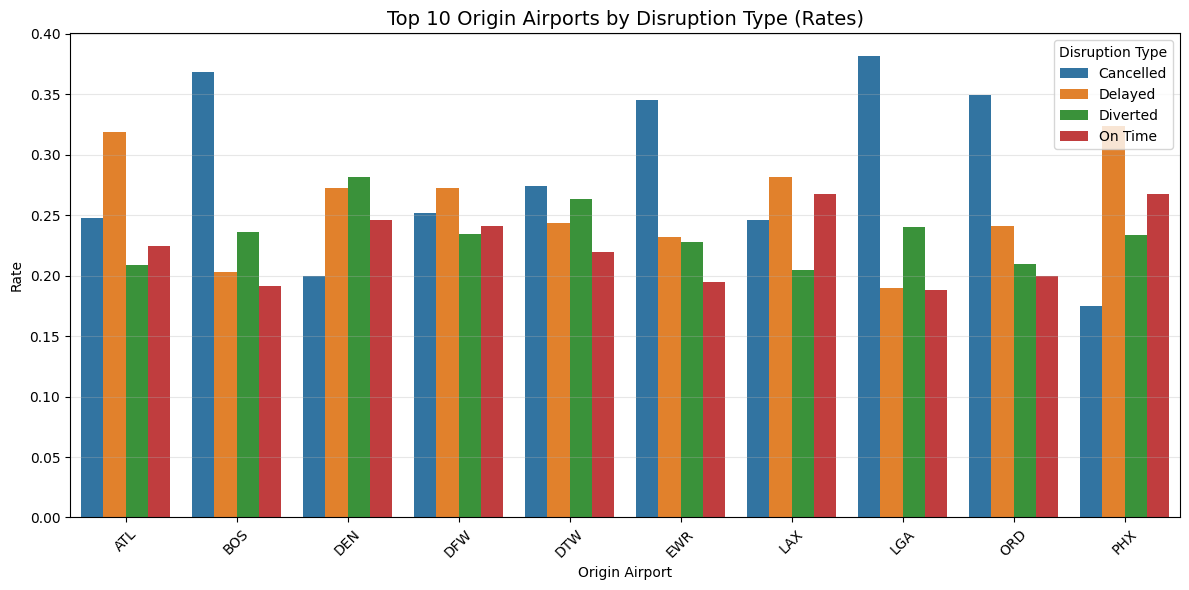

In [31]:
top_origin_airports = df['Origin'].value_counts().head(10).index

origin_total = (
    df[df['Origin'].isin(top_origin_airports)]
    .groupby('Origin')
    .size()
    .reset_index(name='TotalFlights')
)

origin_disruptions = (
    df[df['Origin'].isin(top_origin_airports)]
    .groupby(['Origin', 'DisruptionType'])
    .size()
    .reset_index(name='Count')
)

origin_rates = origin_disruptions.merge(
    origin_total, on='Origin', how='left'
)

origin_rates['Rate'] = (
    origin_rates['Count'] / origin_rates['TotalFlights']
)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=origin_rates,
    x='Origin',
    y='Rate',
    hue='DisruptionType'
)

plt.title('Top 10 Origin Airports by Disruption Type (Rates)', fontsize=14)
plt.xlabel('Origin Airport')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Disruption Type')

plt.tight_layout()
plt.show()


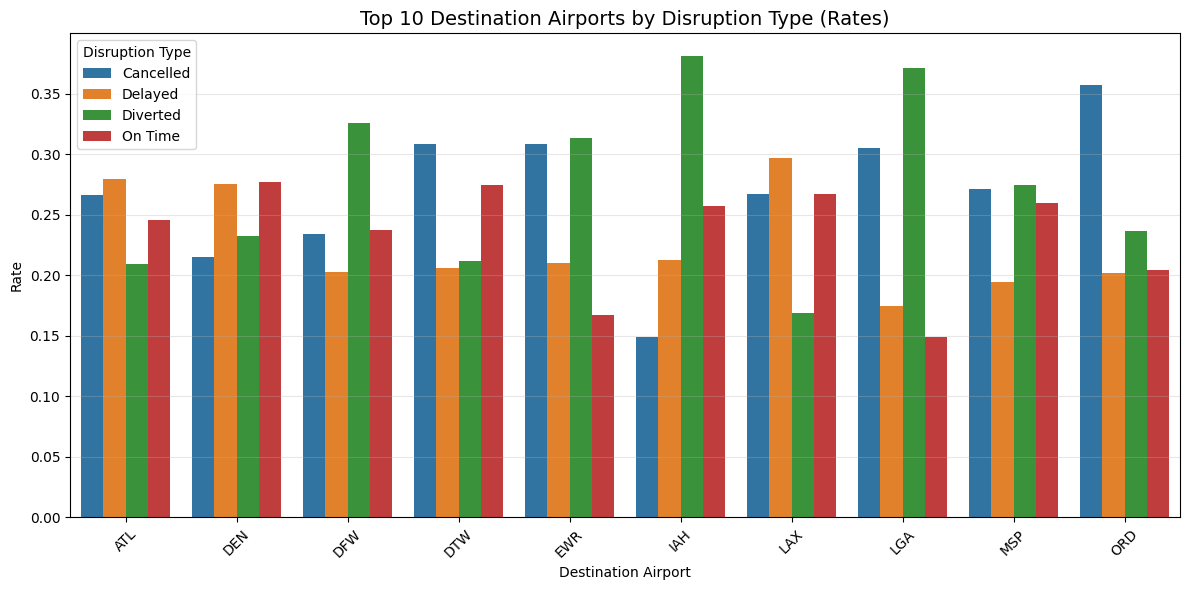

In [32]:
top_dest_airports = df['Dest'].value_counts().head(10).index

dest_total = (
    df[df['Dest'].isin(top_dest_airports)]
    .groupby('Dest')
    .size()
    .reset_index(name='TotalFlights')
)

dest_disruptions = (
    df[df['Dest'].isin(top_dest_airports)]
    .groupby(['Dest', 'DisruptionType'])
    .size()
    .reset_index(name='Count')
)

dest_rates = dest_disruptions.merge(
    dest_total, on='Dest', how='left'
)

dest_rates['Rate'] = (
    dest_rates['Count'] / dest_rates['TotalFlights']
)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=dest_rates,
    x='Dest',
    y='Rate',
    hue='DisruptionType'
)

plt.title('Top 10 Destination Airports by Disruption Type (Rates)', fontsize=14)
plt.xlabel('Destination Airport')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Disruption Type')

plt.tight_layout()
plt.show()


# Applying Origin and Destination Reliability Encoding to Dataset 

In [33]:
origin_reliability=pd.read_csv('C:\\Users\\HP\\OneDrive\\AppData\\Desktop\\!!74 pr\\encodings\\origin_reliability_encoding.csv')
dest_reliability=pd.read_csv('C:\\Users\\HP\\OneDrive\\AppData\\Desktop\\!!74 pr\\encodings\\dest_reliability_encoding.csv')

In [34]:
df = df.merge(origin_reliability, on='Origin', how='left')
df = df.merge(dest_reliability, on='Dest', how='left')

In [35]:
class_df = class_df.merge(origin_reliability, on='Origin', how='left')
class_df = class_df.merge(dest_reliability, on='Dest', how='left')

# Applying Carrier Reliability Encoding to Dataset 

In [36]:
carrier_reliability=pd.read_csv('C:\\Users\\HP\\OneDrive\\AppData\\Desktop\\!!74 pr\\encodings\\carrier_reliability_encoding.csv')

In [37]:
df = df.merge(
    carrier_reliability,
    on='UniqueCarrier',
    how='left'
)

In [38]:
class_df = class_df.merge(
    carrier_reliability,
    on='UniqueCarrier',
    how='left'
)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 39 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   ActualElapsedTime     500000 non-null   float64       
 1   AirTime               352071 non-null   float64       
 2   ArrDelay              500000 non-null   float64       
 3   ArrTime               502804 non-null   float64       
 4   CRSArrTime            1000000 non-null  int64         
 5   CRSDepTime            1000000 non-null  int64         
 6   CRSElapsedTime        994713 non-null   float64       
 7   CancellationCode      79594 non-null    object        
 8   Cancelled             1000000 non-null  int64         
 9   CarrierDelay          263495 non-null   float64       
 10  DayOfWeek             1000000 non-null  int64         
 11  DayofMonth            1000000 non-null  int64         
 12  DepDelay              750162 non-null   flo

In [40]:
class_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 39 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   ActualElapsedTime     500000 non-null   float64       
 1   AirTime               352071 non-null   float64       
 2   ArrDelay              500000 non-null   float64       
 3   ArrTime               502804 non-null   float64       
 4   CRSArrTime            1000000 non-null  int64         
 5   CRSDepTime            1000000 non-null  int64         
 6   CRSElapsedTime        994713 non-null   float64       
 7   CancellationCode      79594 non-null    object        
 8   Cancelled             1000000 non-null  int64         
 9   CarrierDelay          263495 non-null   float64       
 10  DayOfWeek             1000000 non-null  int64         
 11  DayofMonth            1000000 non-null  int64         
 12  DepDelay              750162 non-null   flo

In [ ]:
import pandas as pd

# ----------------------------------
# 1. Define time-of-day bins
# ----------------------------------
time_bins = [0, 360, 600, 840, 1080, 1320, 1440]
time_labels = [
    'Night',
    'Morning',
    'LateMorning',
    'Afternoon',
    'Evening',
    'LateNight'
]

# ----------------------------------
# 2. Create categorical bins
# ----------------------------------
class_df['DepTimeOfDay'] = pd.cut(
    class_df['CRSDepMin'],
    bins=time_bins,
    labels=time_labels,
    right=False
)

class_df['ArrTimeOfDay'] = pd.cut(
    class_df['CRSArrMin'],
    bins=time_bins,
    labels=time_labels,
    right=False
)

# ----------------------------------
# 3. Encode categories as integers
# ----------------------------------
time_encoding = {
    'Night': 0,
    'Morning': 1,
    'LateMorning': 2,
    'Afternoon': 3,
    'Evening': 4,
    'LateNight': 5
}

class_df['DepTimeOfDay_enc'] = class_df['DepTimeOfDay'].map(time_encoding)
class_df['ArrTimeOfDay_enc'] = class_df['ArrTimeOfDay'].map(time_encoding)

# ----------------------------------
# 4. Optional: drop string columns
# ----------------------------------
class_df.drop(columns=['DepTimeOfDay', 'ArrTimeOfDay'], inplace=True)

# Dropping Useless Features 
# Final Feature count : 12

In [ ]:
DROP_ALWAYS = [
'CRSElapsedTime',
'Origin',
'Dest',
'Date',
'Year',
'UniqueCarrier',
'DistanceBin',
'ElapsedBin',
'ArrTime',          
'DepTime',        
'TaxiIn',          
'TaxiOut',          
'Cancelled',        
'Diverted',         
'FlightNum', 
'AirTime',
'ArrDelay',          
'DepDelay',
'CancellationCode',
'AirTime',
'ArrDelay',          
'DepDelay',
'CancellationCode',
'DepDelay',
'CarrierDelay',
'WeatherDelay',
'LateAircraftDelay',
'NASDelay',
'SecurityDelay',
'CRSArrTime',
'CRSDepTime',
'Total_Delay','ActualElapsedTime'
]
class_df.drop(columns=DROP_ALWAYS, inplace=True)

In [61]:
class_df=class_df.dropna(subset=['Distance'])

In [5]:
class_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   DayOfWeek             999999 non-null  int64   
 1   DayofMonth            999999 non-null  int64   
 2   Distance              999999 non-null  float64 
 3   Month                 999999 non-null  int64   
 4   DisruptionType        999999 non-null  object  
 5   CRSDepMin             999999 non-null  int64   
 6   CRSArrMin             999999 non-null  int64   
 7   ScheduledElapsedTime  999999 non-null  int64   
 8   OriginReliability     999999 non-null  float64 
 9   DestReliability       999999 non-null  float64 
 10  CarrierReliability    999999 non-null  float64 
 11  DepTimeOfDay_enc      999999 non-null  category
 12  ArrTimeOfDay_enc      999999 non-null  category
dtypes: category(2), float64(4), int64(6), object(1)
memory usage: 85.8+ MB


In [6]:
class_df.to_csv('Flight_classification_data.csv', index=False)

In [ ]:
df.to_csv('Balanced_flight_data1.csv', index=False)